In [25]:
legi:20-811-964 

# SLT-CE-4: Constant Shift Embedding

## Task

Many real-world phenomena are described by pairwise proximity data, modeling interactions between the entities of the system. This in contrast to the more common situation where each data sample is given as a feature vector. Even though the clustering of the proximity data may be performed directly on the data matrix, there are some advantatages of  embedding the data into a vector space. For example, it enables the use of some standard preprocessing techniques such as denoising or dimensionality reduction. In this coding exercise, we will explore the tecnhique called _Constant Shift Embedding_ for restating pairwise clustering problems in vector spaces [1] while preserving the cluster structure. We will apply the algorithm described in [1] to cluster the groups of research community members based on the email correspondence matrix. The data and its description is given in [2].

### References 

[1] [Optimal cluster preserving embedding of nonmetric proximity data](https://ieeexplore.ieee.org/document/1251147)

[2] [email-Eu-core](https://snap.stanford.edu/data/email-Eu-core.html)

 <h2 style="background-color:#f0b375;"> Setup </h2>

We start by importing necessary python packages.

In [26]:
import numpy as np
import sklearn as skl
import matplotlib.pylab as plt
import pylab
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans

import scipy.linalg as la
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

# Fix randoom seed for reproducibility
np.random.seed(42)

The number of nodes is hardcoded for simplicity (taken from [2]):

In [27]:
NUM_NODES = 1005

We load the file which contains the list of interactions between the community members (nodes). Our data matrix represents an undirected graph which connects two nodes if there was at least one email sent between the two corresponding community members. Thus our data matrix is essentially an adjacency matrix.

In [28]:
# initialize data matrix which will be an adjacency matrix
DATA = np.zeros((NUM_NODES, NUM_NODES))

# fill out the symmetric adjacency matrix
with open("email-Eu-core.txt") as file:
    for line in file:
        pair = [int(x) for x in line.split()]
        DATA[pair[0], pair[1]] = 1
        DATA[pair[1], pair[0]] = 1

Note that DATA specifies an adjacency matrix of the email graph. It's not claimed to be a proper dissimilarity matrix required by CSE algorithm. So, you are allowed to perform any manipulations to construct a suitable (dis-)similarity matrix for the further analysis.

Next we define a class which contains main functionalities - TO BE IMPLEMENTED.

In [29]:
from sklearn.preprocessing import normalize



class ConstantShiftEmbedding(skl.base.BaseEstimator, skl.base.TransformerMixin):
    """Template class for Constant Shift Embedding (CSE)
    
    Attributes:
        PMAT (np.ndarray): Proximity matrix used for calculating the embeddings.
        S (np.ndarray): Similarity matrix.
        D (np.ndarray): Dissimilarity matrix.
        
    """
    
    def __init__(self):
        self.PMAT = None
        self.S = None
        self.D = None
        # Add/change parameters, if necessary.
    
    def centralize(self, D):
        n = D.shape[0]
        ones = np.ones((n,n))
        I = np.eye(n) - (1/n) * ones
        Dc = I @ D @ I
        return Dc


    def eigenvalues(self):
        eigenvalues, eigenvectors = np.linalg.eigh(self.S)
        descending_indices = np.argsort(eigenvalues)[::-1]
        sorted_eigenvalues = eigenvalues[descending_indices]
        sorted_eigenvectors = eigenvectors[:, descending_indices]
        
        sorted_eigenvalues[sorted_eigenvalues < 0] = 0
        
        return sorted_eigenvalues, sorted_eigenvectors



    def fit(self, PMAT):
        """ Calculate similarity/dissimiliarity matrix and all
        the necessary variables for calculating the embeddings.
        
        Args:
            PMAT (np.ndarray): proximity matrix
        """
        # Save data
        self.PMAT = PMAT

        n = PMAT.shape[0]

        ## IMPLEMENT THIS METHOD
        for i in range(PMAT.shape[0]):
            PMAT[i,i] = 1

        n = PMAT.shape[0]
        D = np.zeros((n, n))
        for i in range(n):
            intersection = np.logical_and(PMAT[i, np.newaxis, :], PMAT)
            union = np.logical_or(PMAT[i, np.newaxis, :], PMAT)
            D[i, :] = 1 - np.sum(intersection, axis=1) / np.sum(union, axis=1)
        
        D = 1/2 * (D + D.T)

        Dc = self.centralize(D)
        Sc = -1/2 * Dc
        lambdas = np.linalg.eigvals(Sc)
        lambda_min = np.min(lambdas)
        S_tilde = Sc - lambda_min * np.eye(n)
        
        S_tilde_c = self.centralize(S_tilde)
        self.S = S_tilde_c
        
        D_tilde = D - 2 *  lambda_min  * (np.ones(n) -  np.eye(n))
        D_tilde_c = self.centralize(D_tilde)
        self.D = D_tilde_c
        return self
        
    def get_embedded_vectors(self, p):
        """Return embeddings
        
        Args:
            p (np.ndarray): cut-off value in eigenspectrum
        
        Returns:
            Xp (np.ndarray): embedded vectors
        
        """
        
        ## IMPLEMENT THIS METHOD
        S_eigenvalues, S_eigenvectors = self.eigenvalues()
        sqrt_lambdas = np.sqrt(np.diag(S_eigenvalues[:p]))
        Vp = S_eigenvectors[:,:p]
        Xp = Vp @ sqrt_lambdas

        S_tilde = Xp @ Xp.T
        D_tilde = np.zeros(S_tilde.shape)
        
        for i in range(self.PMAT.shape[0]):
            for j in range(self.PMAT.shape[1]):
                D_tilde[i,j] = S_tilde[i,i] + S_tilde[j,j] - 2 * S_tilde[i,j]
        
        return Xp, D_tilde


<h2 style="background-color:#f0b375;">
Section 4.0 
<span style=font-size:50%> Complete all problems in this section to get a pass on this exercise. </span>
</h2>

<p style="background-color:#adebad;">Describe briefly and consicely the model given in [1]. Explain the main steps of _Constant Shift Embedding_ algorithm. See <a href="https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebook_list-cheatsheet-386c05aeebed">markdown cheatsheet</a> for text editing.</p>


- **Constant Shift Embedding**: 
Given a dissimilarity matrix D, we want to perform clustering on the data as we would with euclidean data. To do that we can perform matrix manipulations on our matrix D. Note that D must have zero diagonal entries.
We perform the following manupulations:
First if we are given data which isn't a dissimilarity matirx we have to transform using a similarity/dissimiliarty metric.
We them centralize D using the following formula: $D^{c} := (I - \frac{1}{n}1_n)D(I - \frac{1}{n}1_n)$.
We then compute the Gram matrix: $S^{c} = -\frac{1}{2}D^{c}$. 
We make $S^{c}$ positive semi definite,by constant shifting:
$\tilde{S}_{ij} = \tilde{S}^{c}_{ij} - \lambda(S^c)_{min}\delta_{ij}$. 
Finally, we get our final matrix $\tilde{D}$: $\tilde{D}_{ij}=\tilde{S}_{ii}+\tilde{S}_{jj}-2\tilde{S}_{ij}$. 
The crucial part is that if $S^{c}$ is PSD, the elements of D will be mapped to squared euclidean distances. 


<p style="background-color:#adebad;">
    Implement Constant Shift Embedding. We start off by making an instance of the corresponding class.
</p>    

In [30]:
CSE = ConstantShiftEmbedding()

<p style="background-color:#adebad;">
    Fit the data matrix. _fit(...)_ method computes necessary variables which can be later on used to produce embeddings [1].
</p>    

In [31]:
CSE.fit(DATA)

ConstantShiftEmbedding()

<h2 style="background-color:#f0b375;">
Section 4.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 4.5 </span>
</h2>

<p style="background-color:#adebad;">
    Next, try to find approximately optimal $p = p^∗$, a cut-off value which removes noise from the data. To do that, produce an eigen-spectrum plot as shown in [1] figure 4a and briefly explain your choice of $p^∗$.
</p>

Text(0.5, 1.0, 'Eigen-spectrum')

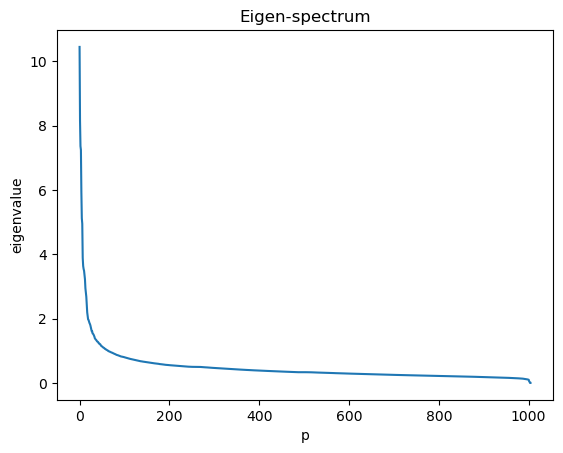

In [32]:
## Compute eigen-spectrum
num = np.arange(NUM_NODES)
eigenvalues, _ = CSE.eigenvalues()
plt.figure()
plt.plot(num, eigenvalues)
plt.xlabel('p')
plt.ylabel('eigenvalue')
plt.title('Eigen-spectrum')

In [33]:
## Determine a good cut-off value (and write some lines to explain your choice)
p_opt = 40 ## change accordingly
print("Chosen cut-off value is: ", p_opt)

Chosen cut-off value is:  40


We choose p = 40 using the elbow method, we want the lowest p with the lowest value

Text(0.5, 1.0, 'Eigen-spectrum with cut-off value')

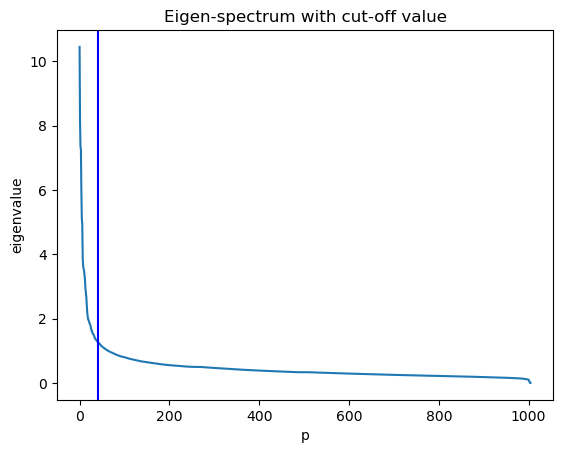

In [34]:
## Plot spectrum and indicate the cut-off value on the spectrum
plt.figure()
plt.plot(np.arange(NUM_NODES), eigenvalues)
plt.axvline(x=p_opt, color='b')
plt.xlabel('p')
plt.ylabel('eigenvalue')
plt.title('Eigen-spectrum with cut-off value')

<h2 style="background-color:#f0b375;">
Section 5.0 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.0 </span>
</h2>

<p style="background-color:#adebad;">
    Plot the distance matrices both for the denoised ($p = p^*$ -- from the previous step) and the original versions as shown in figure 5 in [1]. Note that the distance matrix is a matrix with pairwise distances between every two points from the dataset ($d_{ij} = dist(x_i, x_j)$).<br>
    Perform K-MEANS algorithm for varying number of clusters K on the embedded vectors derrived from CSE. You may use the sklearn implementation of K-MEANS. To make the aforementioned plots meaningful, sort the nodes according to the cluster belongings for every number of clusters K (see the figure 5). For now, there is no need to include the actual ground truth labels given in [2].
</p>

/Users/marvin/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/marvin/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


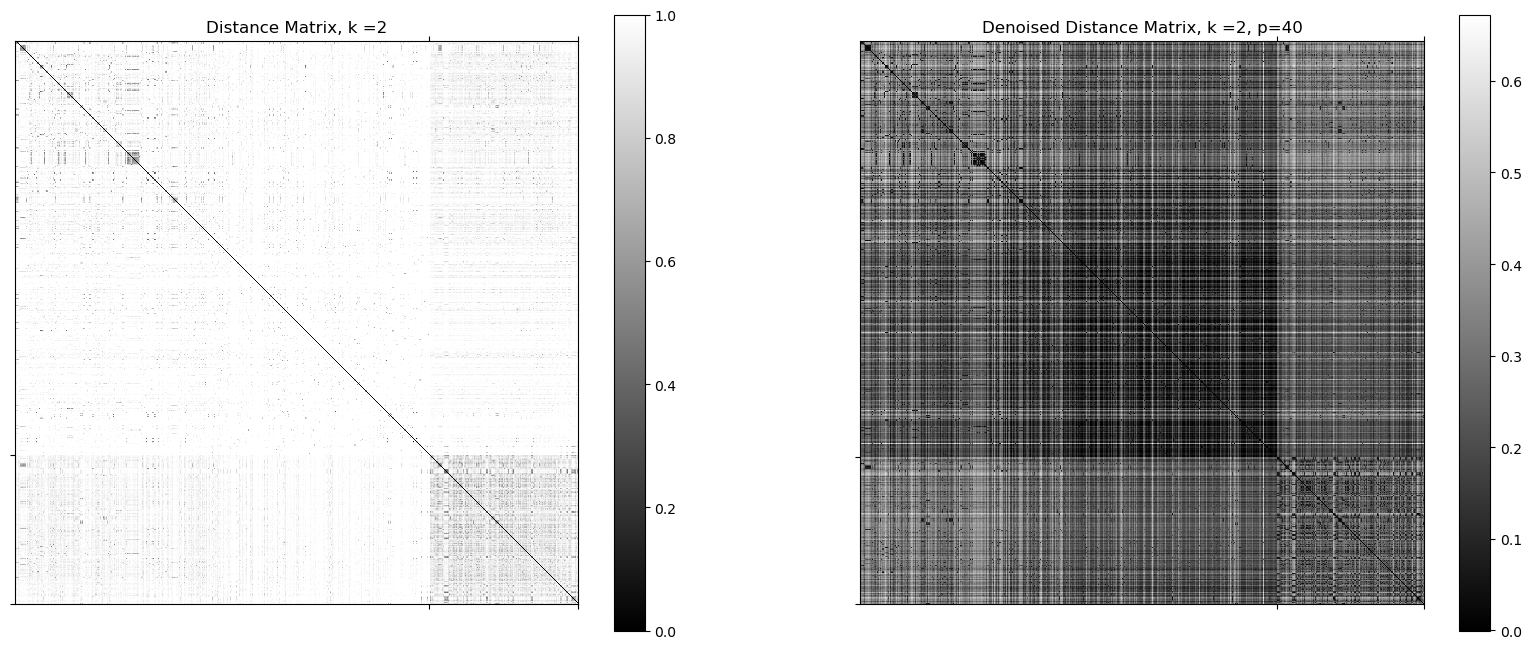

/Users/marvin/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/marvin/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


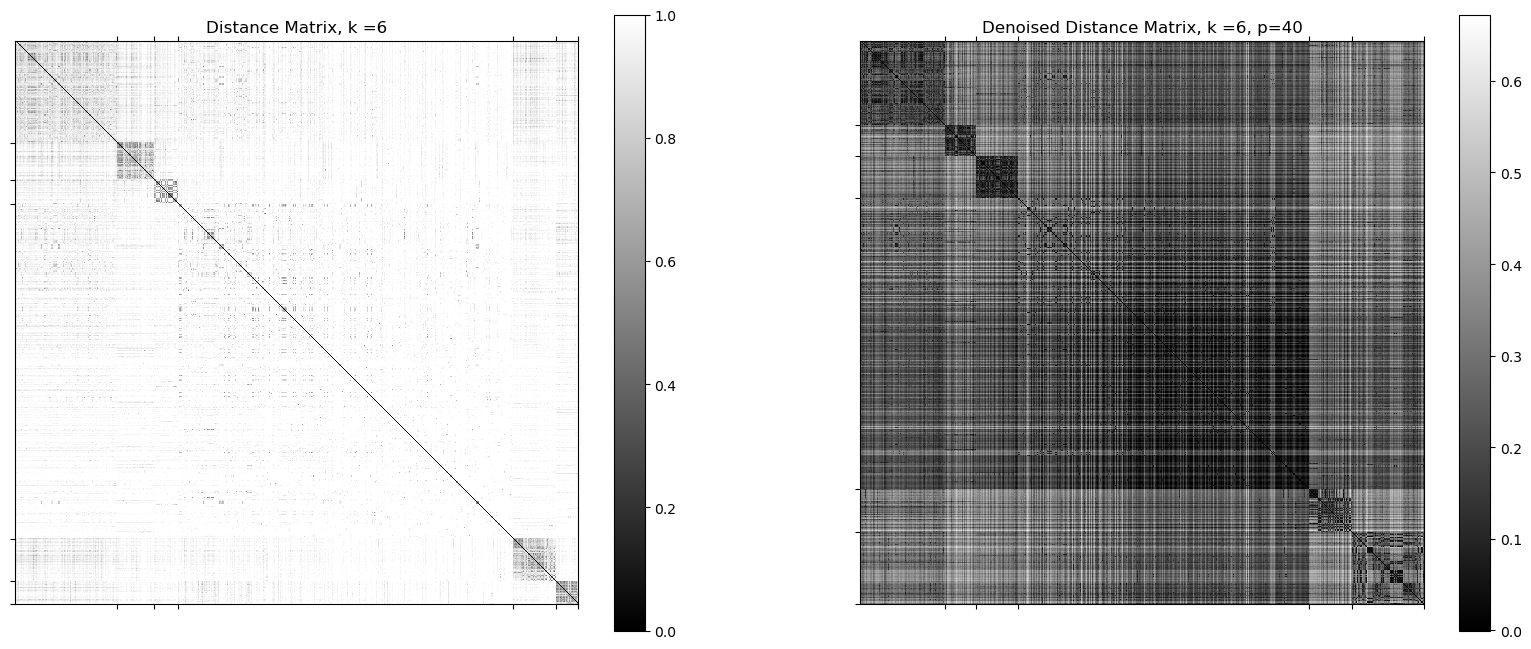

/Users/marvin/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/marvin/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


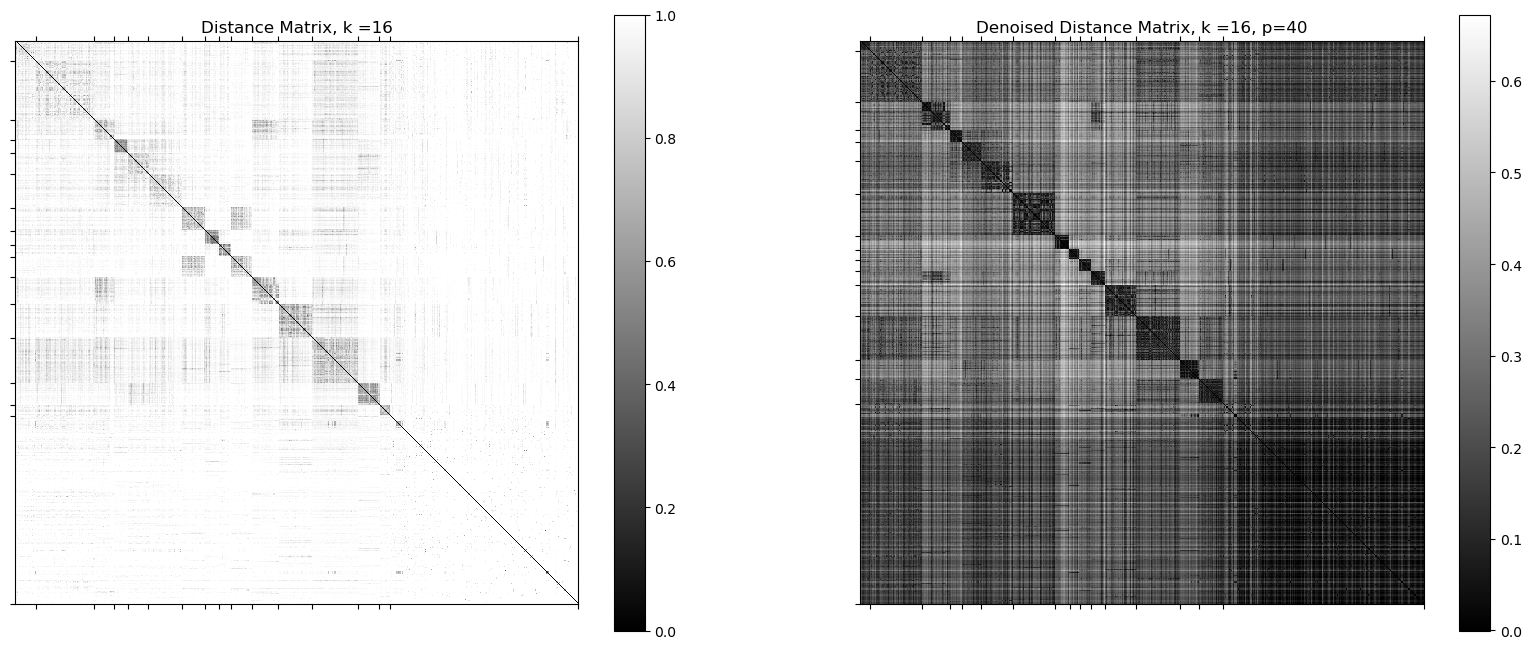

/Users/marvin/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/marvin/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


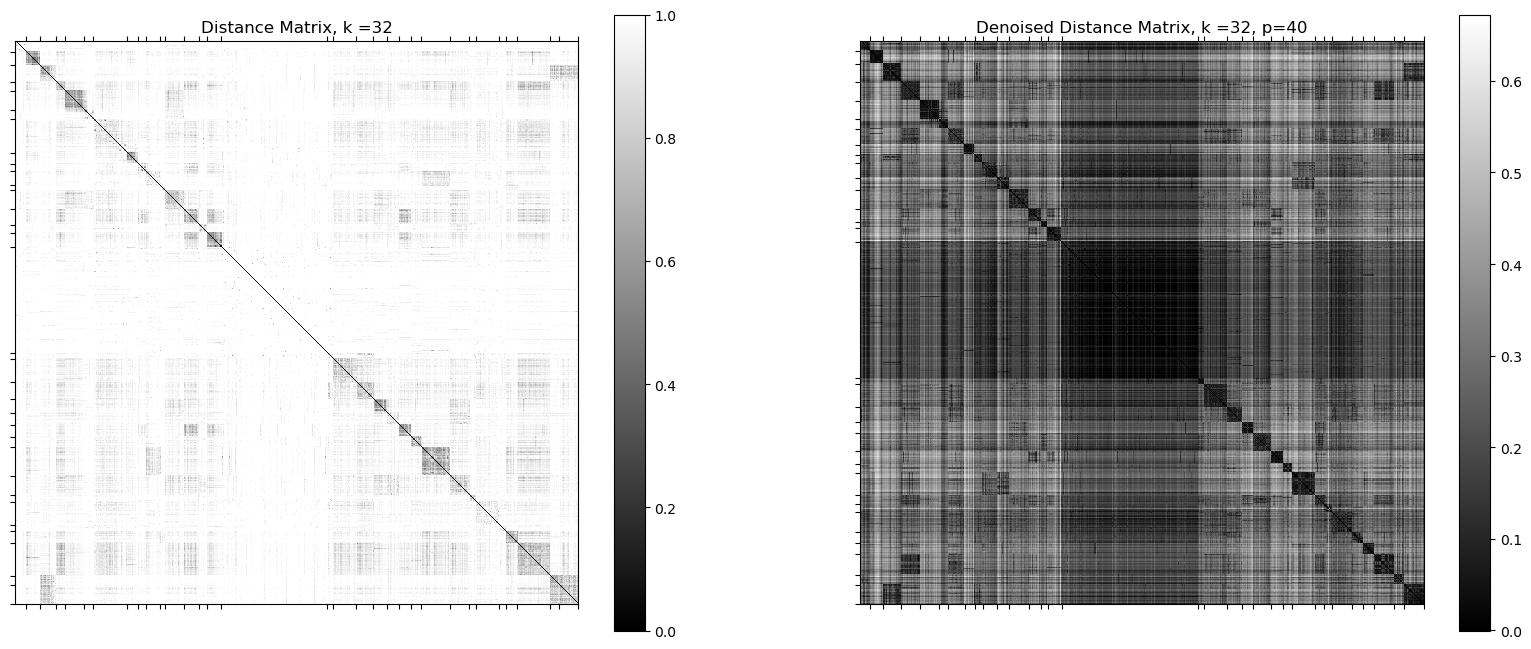

In [35]:
## Distance matrices

import sklearn
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances

import scipy
from scipy.optimize import linear_sum_assignment as linear_assignment

embedded_vectors_denoised, dissimilarity_matrix_denoised = CSE.get_embedded_vectors(p_opt)
embedded_vectors_true, dissimilarity_matrix_true = CSE.get_embedded_vectors(NUM_NODES)

for k in [2, 6, 16, 32]:
    kmeans_true = KMeans(n_clusters=k, random_state=5000).fit(embedded_vectors_true)
    labels_true = kmeans_true.predict(embedded_vectors_true)
    
    model = KMeans(n_clusters=k, random_state=5000)
    pred = model.fit(embedded_vectors_denoised)
    labels_denoised = pred.predict(embedded_vectors_denoised)

    confusion_matrix = sklearn.metrics.confusion_matrix(labels_true, labels_denoised)
    assignments = np.array(linear_assignment(-confusion_matrix.T))
    adjusted_labels = []

    for i in range(labels_denoised.shape[0]):
        adjusted_labels.append([assignments[1][labels_denoised[i]]])
    adjusted_labels_denoised = np.array(adjusted_labels)
    
    partition_denoised, idx_denoised, partition_true, idx_true = [], [], [], []
    for i in range(k):
        ids = np.where(adjusted_labels_denoised==i)[0]
        partition_denoised.append(ids)
        idx_denoised.append(ids.size)

        ids = np.where(labels_true==i)[0]
        partition_true.append(ids)
        idx_true.append(ids.size)

    partition_denoised = np.concatenate(partition_denoised)
    partition_true = np.concatenate(partition_true)

    d_denoised = dissimilarity_matrix_denoised.copy()
    d_denoised = d_denoised[partition_denoised,:]
    d_denoised = d_denoised[:, partition_denoised]
    permuted_dissimilarity_denoised = d_denoised
    
    d_true = dissimilarity_matrix_true.copy()
    d_true = d_true[partition_true,:]
    d_true = d_true[:, partition_true]
    permuted_dissimilarity_true = d_true

    plt.figure(figsize=(20,8))
    plt.subplot(121)
    plt.matshow(permuted_dissimilarity_true, fignum=False, cmap=plt.cm.gray)
    parts = ['']* len(idx_true)
    plt.xticks(np.cumsum(idx_true)-0.5, parts)
    plt.yticks(np.cumsum(idx_true)-0.5, parts)
    plt.title('Distance Matrix, k =' + str(k))
    plt.colorbar()

    plt.subplot(122)
    plt.matshow(permuted_dissimilarity_denoised, fignum=False, cmap=plt.cm.gray)
    parts = ['']* len(idx_denoised)
    plt.xticks(np.cumsum(idx_denoised)-0.5, parts)
    plt.yticks(np.cumsum(idx_denoised)-0.5, parts)
    plt.title('Denoised Distance Matrix, k =' + str(k) + ', p=' + str(p_opt))
    plt.colorbar()

    plt.show()
    


<h2 style="background-color:#f0b375;">
Section 5.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.5 </span>
</h2>

<p style="background-color:#adebad;">
    Producing 2D and 3D embeddings allows us to nicely visualize generated clusters. Now calculate the embeddings for p = 2 (2D case) and p = 3 (3D case) and plot clusterings for a few values of K.  Alternatively, you could use $p = p^*$ for more gentle denoising, cluster the denoised embeddings and only then apply a dimensionality reduction technique to get a plot in 2,3-dimensional space. You could use PCA, LLE, t-SNE etc. figure out what works for you. As an example see figure 6 (b) from [1] where CSE is combined with PCA.
</p>

In [36]:
## Get embeddings, run K-MEANS and generate plots
def plot_embeddings(X, p, k_list=[2,6,16,32]): 
    fig = plt.figure(figsize=(40,6))
    for i, k in enumerate(k_list):
        ax = fig.add_subplot(1, 7, i+1, projection=('3d' if p == 3 else None))
        ax.set_title('k = ' + str(k))
        model = KMeans(n_clusters=k, random_state=5000)
        model.fit(X)
        pred = model.predict(X)
        for i in range(k):
            idx = np.where(pred == i)
            args = [X[idx, 0], X[idx, 1]]
            if p == 3:
                args.append(X[idx, 2])
            ax.scatter(*args)
    plt.show()

/Users/marvin/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/marvin/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/marvin/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/marvin/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


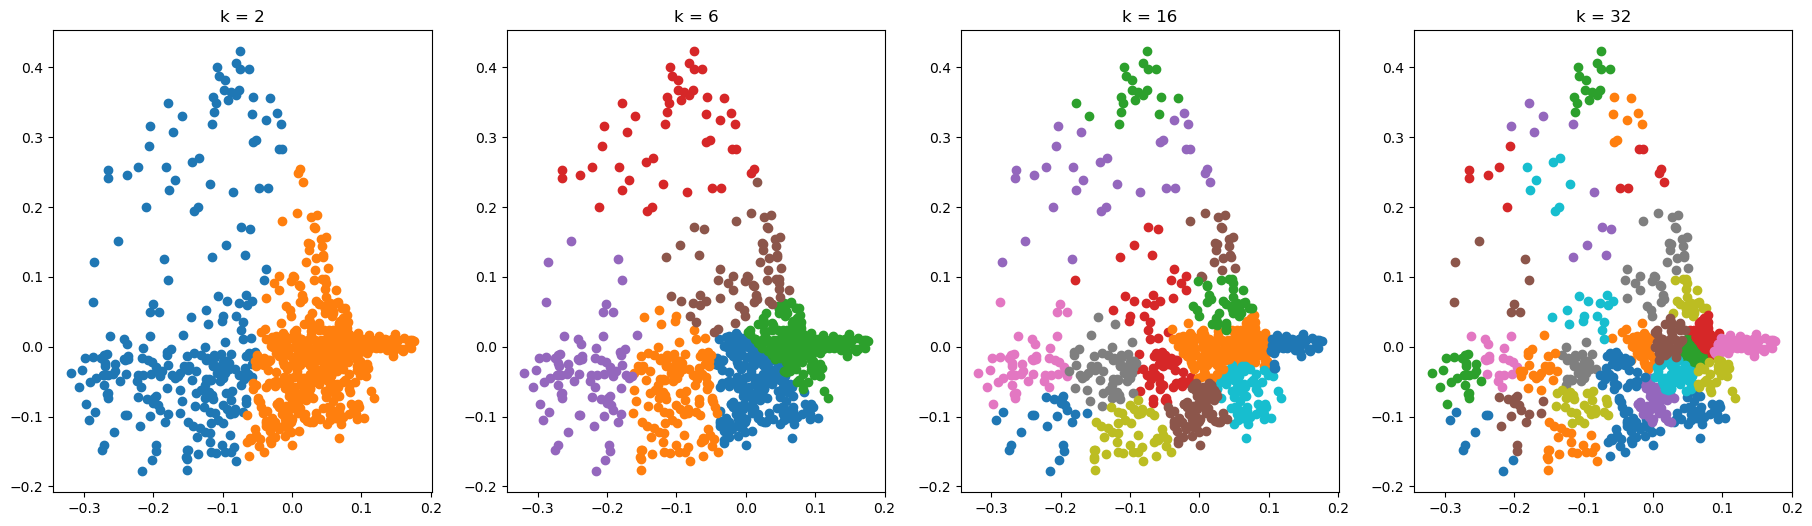

In [37]:
p = 2
Xp_2, _ = CSE.get_embedded_vectors(p)
plot_embeddings(Xp_2, p)

/Users/marvin/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/marvin/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/marvin/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/marvin/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


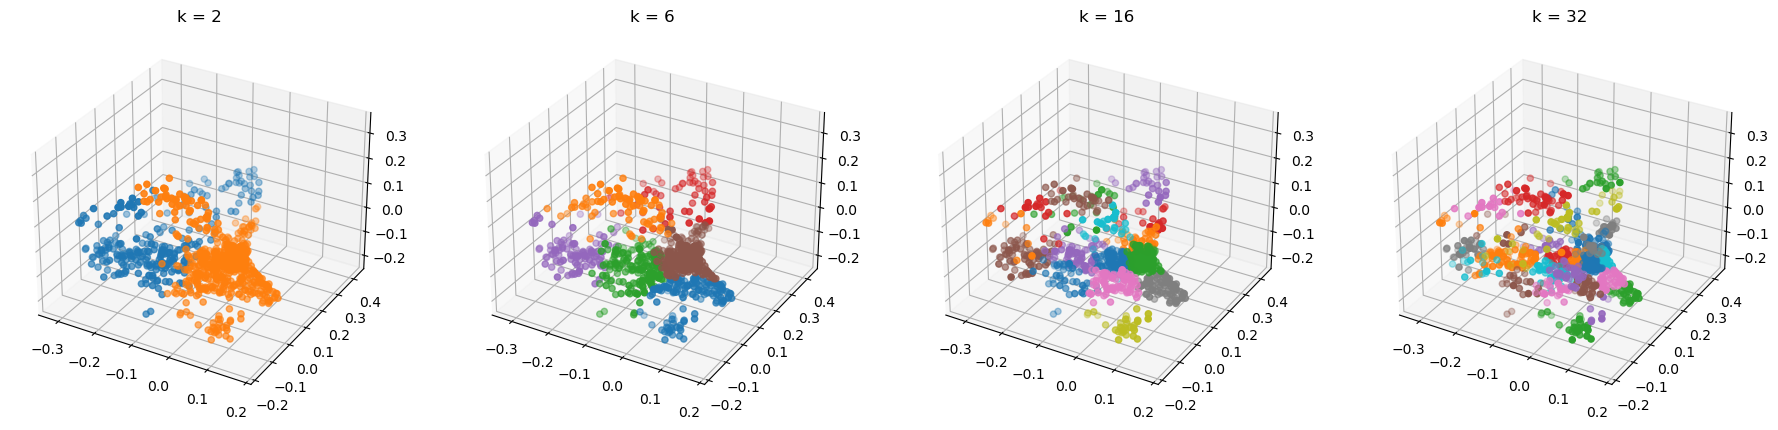

In [38]:
p = 3
Xp_3,_ = CSE.get_embedded_vectors(p)
plot_embeddings(Xp_3, p)

/Users/marvin/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/marvin/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/marvin/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/marvin/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


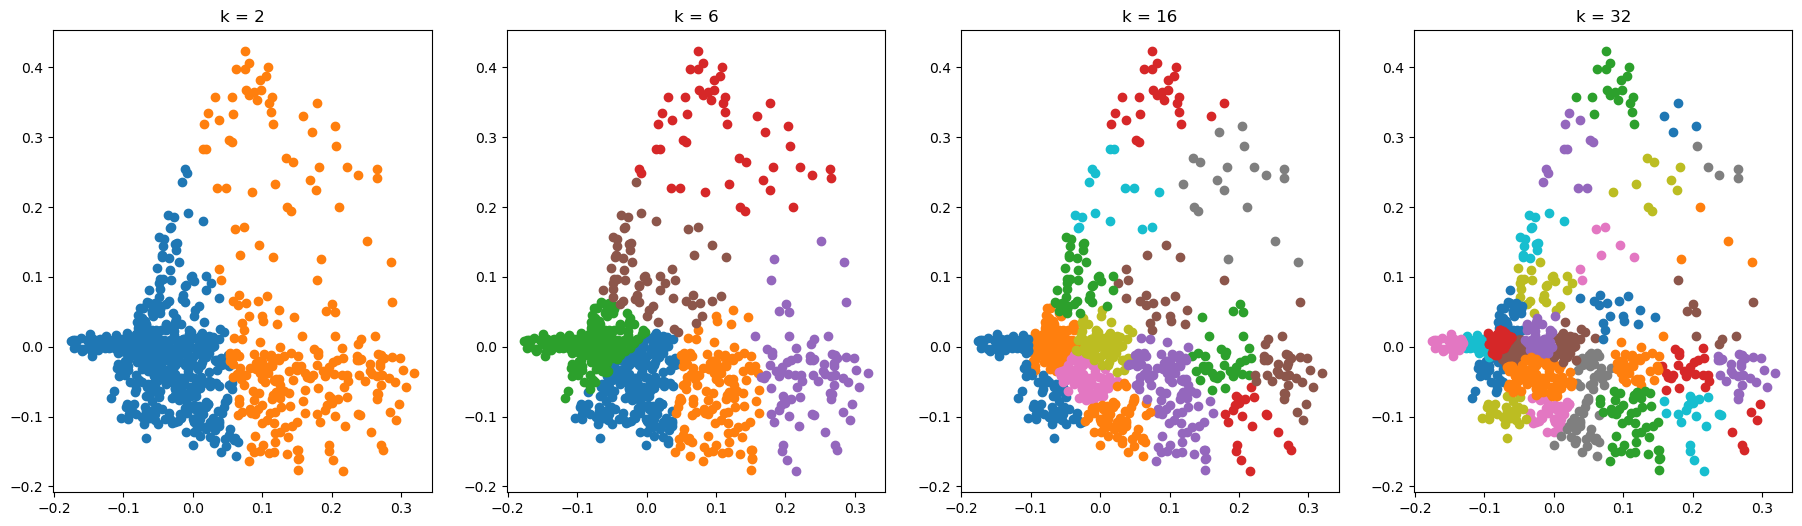

In [39]:
## choose p > 3, for example, p = p_opt, to compute CSE embeddings 
## First, cluster the computed p-dimentional embeddings and then project them onto 2-dimensional space 
## for visualization using PCA, LL, t-SNE or something else
from sklearn.decomposition import PCA
Xp_opt, _ = CSE.get_embedded_vectors(p_opt)
pca = PCA(n_components=2, random_state=5000)
Xp_opt_pca = pca.fit_transform(Xp_opt)
plot_embeddings(Xp_opt_pca, 2)




<h2 style="background-color:#f0b375;">
Section 6.0 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 6.0 </span>
</h2>

<p style="background-color:#adebad;">
Finally, to evaluate the quality of the above derived clusters, let's compare our predictions with the ground truth. We will use the actual member-institution mappings given in [2]. You can reuse code from the previous coding exercises to align the cluster labels with the ground truth.
</p>

In [40]:
# Initialize community members affeliation array
AFFILIATIONS = np.zeros((NUM_NODES, ))

# Fill out the affiliation array
with open("email-Eu-core-department-labels.txt") as file:
    for line in file:
        pair = [int(x) for x in line.split()]
        AFFILIATIONS[pair[0]] = pair[1]

# Number of organizations is 
print("The true number of clusters (departments) is: ",len(np.unique(AFFILIATIONS)))

The true number of clusters (departments) is:  42


<p style="background-color:#adebad;">
Visually or quantitatively, in a clever and convincing way, show that the K-MEANS generated clusters overlap with the ground truth clusters (member affiliations). How can we measure the overlapping of the predicted and true clusters?
</p>

/Users/marvin/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


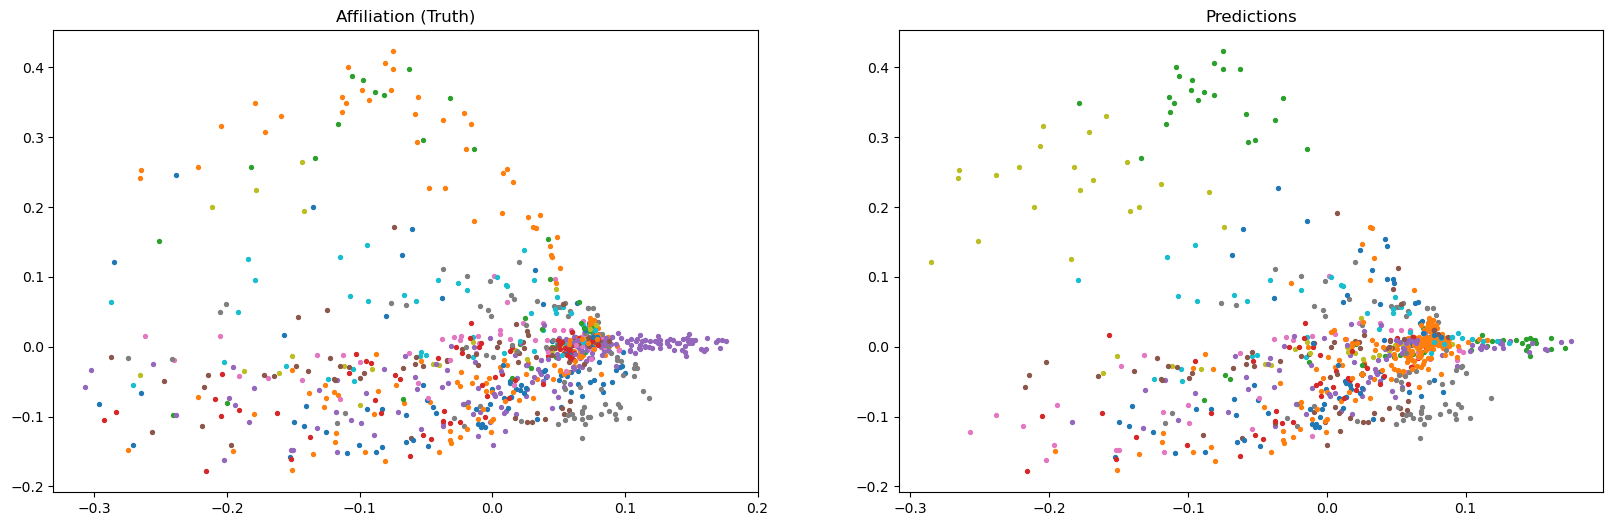

Accuracy:  0.40497512437810945


In [41]:
## Here you can provide plots and calculations
labels_denoised = KMeans(n_clusters=len(np.unique(AFFILIATIONS)), random_state=5000).fit(Xp_opt).predict(Xp_opt)
confusion_matrix = sklearn.metrics.confusion_matrix(AFFILIATIONS, labels_denoised)
assignments = np.array(linear_assignment(-confusion_matrix.T))
adjusted_labels = []
for i in range(labels_denoised.shape[0]):
    adjusted_labels.append([assignments[1][labels_denoised[i]]])
adjusted_labels_denoised = np.array(adjusted_labels)

plt.figure(figsize=(20, 6))
plt.subplot(121)
for i in range(k):
    id_ = np.where(AFFILIATIONS == i)
    plt.scatter(Xp_opt[id_,0], Xp_opt[id_,1], marker='o', s=8, label=str(i))   

plt.title('Affiliation (Truth)')
plt.subplot(122)

for i in range(k):
    id_ = np.where(adjusted_labels_denoised == i)
    plt.scatter(Xp_opt[id_,0], Xp_opt[id_,1], marker='o', s=8, label=str(i))

plt.title('Predictions')
plt.show()

print("Accuracy: ", accuracy_score(AFFILIATIONS, adjusted_labels_denoised))


Please, write here your explanations, observation and thoughts about results of the experiments above.

One interesting observation is that the value p that we chose using the elbow method is very close to the number of cluster in the truth (40 and 42).

Using the visualization and the accuracy score between the truth and our prediciton, we can see that our model can't totally capture the true clusters.
Maybe the dissimilarity metric used (Jaccard) isn't the best one, or we have to choose p = 42

## Comments

We hope you found this exercise instructive.

Feel free to leave comments below, we will read them carefully.